# Análisis ANOVA de Dimensiones de Respuesta

Este notebook realiza análisis de varianza (ANOVA) para examinar la variabilidad de términos en diferentes dimensiones semánticas de respuestas generadas por modelos de lenguaje.

## Funcionalidades

1. **Carga de Datos CSV**: Lee archivos CSV con respuestas estructuradas
2. **Separación por Dimensiones**: Divide respuestas usando separadores `|`
3. **Análisis ANOVA**: Compara variabilidad entre dimensiones
4. **Visualizaciones**: Gráficos comprensivos de los resultados
5. **Exportación**: Guarda resultados para análisis posterior

> Este notebook fue desarrollado con asistencia de IA (Github Copilot) para que el código implementado se alineara un estilo de codificación acorde con proyectos de ML en python.  El alcance, metodología, definición de entradas y salidas, transformaciones de datos, revisión y análisis de los reslultados y revisión de código estuvieron a cargo del equipo de trabajo.  

## Instrucciones de uso

### Formato del archivo CSV requerido

El archivo CSV debe contener las siguientes columnas:

- **`food_item`**: Elemento de comida analizado (ej: "chocolate", "kadhi")
- **`template_name`**: Nombre de la plantilla usada para generar la respuesta
- **`response`**: Respuesta con dimensiones separadas por `|` (pipe)
- **`success`**: Booleano indicando si la respuesta fue exitosa (True/False)

### Ejemplo de formato de respuesta:

```
rich, creamy, sweet | indulgence, satisfaction | warm | smooth, velvety | happiness | brown | sweet
```

### Dimensiones esperadas (en orden):

1. **sensations**: Perfil de sabor químico
2. **human_responses**: Respuestas fisiológicas humanas  
3. **temperature**: Temperatura asociada
4. **texture**: Características de textura
5. **emotions**: Emociones evocadas
6. **color**: Color asociado
7. **taste**: Sabor básico

### Para usar este notebook:

1. **Cambiar la ruta del archivo CSV** en la sección 2
2. **Ejecutar todas las celdas** secuencialmente
3. **Revisar visualizaciones** y resumen estadístico

### Interpretación de resultados:

- **F-statistic alto + p < 0.05**: Diferencias significativas entre dimensiones
- **Diversidad alta**: Mayor variabilidad léxica en la dimensión
- **Comparaciones pareadas**: Identifica qué dimensiones difieren significativamente

## 1. Import Required Libraries

Importamos todas las librerías necesarias para el análisis ANOVA y visualizaciones.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import f_oneway
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any
import warnings
# Importar el módulo de configuración
from config.config import load_config, setup_project_paths, PROJECT_ROOT
warnings.filterwarnings('ignore')

# Import wordcloud for text visualization
try:
    from wordcloud import WordCloud
    wordcloud_available = True
    print("✅ WordCloud disponible")
except ImportError:
    wordcloud_available = False
    print("⚠️  WordCloud no disponible. Instalar con: pip install wordcloud")

print("✅ Librerías importadas correctamente")

✅ WordCloud disponible
✅ Librerías importadas correctamente


## 2. Load Data from CSV File

Carga los datos desde un archivo CSV que contiene respuestas estructuradas con una columna 'response'.

In [2]:
# Configurar directorios del proyecto y cargar configuración
setup_project_paths()  # Crea todos los directorios necesarios
config = load_config()

# Configuración del archivo CSV
CSV_FILE_PATH = PROJECT_ROOT / config.data.cleaned_data_path / "food/prompt_experiment_results_20251106_181848.csv"  # Cambiar por tu archivo

In [4]:
def load_csv_data(file_path: str) -> pd.DataFrame:
    """
    Carga datos desde un archivo CSV
    
    El CSV debe contener al menos las siguientes columnas:
    - 'food_item': Elemento de comida analizado
    - 'template_name': Nombre de la plantilla usada
    - 'response': Respuesta con dimensiones separadas por '|'
    - 'success': Indicador booleano de respuesta exitosa
    
    Args:
        file_path: Ruta al archivo CSV
    
    Returns:
        DataFrame con los datos cargados
    """
    try:
        df = pd.read_csv(file_path)
        
        # Validar columnas requeridas
        required_columns = ['food_item', 'template_name', 'response', 'success']
        missing_columns = [col for col in required_columns if col not in df.columns]
        
        if missing_columns:
            print(f"⚠️  Columnas faltantes: {missing_columns}")
            print(f"Columnas disponibles: {list(df.columns)}")
            return pd.DataFrame()
        
        print(f"✅ Archivo cargado exitosamente!")
        print(f"Shape: {df.shape}")
        print(f"Respuestas exitosas: {df['success'].sum()}/{len(df)}")
        
        return df
        
    except FileNotFoundError:
        print(f"❌ Archivo no encontrado: {file_path}")
        return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error cargando archivo: {e}")
        return pd.DataFrame()

print("📁 Configuración del archivo:")
print(f"Ruta: {CSV_FILE_PATH}")

# Cargar datos
df = load_csv_data(CSV_FILE_PATH)
# Usar solo los primeros 10 registros para vista previa
results_df = df.head(10)

📁 Configuración del archivo:
Ruta: /Users/jorge/workspace/personal/aws/maia/audio_reprompt/data/cleaned/food/prompt_experiment_results_20251106_181848.csv
✅ Archivo cargado exitosamente!
Shape: (10, 5)
Respuestas exitosas: 10/10


## 3. Split Response Values by Dimensions

Separamos las respuestas usando el separador `|` y creamos nuevas dimensiones.

In [5]:
def split_responses_by_dimensions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Separa las respuestas en dimensiones usando el separador '|'
    
    Args:
        df: DataFrame con columna 'response'
    
    Returns:
        DataFrame expandido con columnas para cada dimensión
    """
    # Filtrar solo respuestas exitosas y no nulas
    valid_responses = df[df['success'] == True]['response'].dropna()
    
    if len(valid_responses) == 0:
        print("⚠️  No hay respuestas válidas para analizar")
        return pd.DataFrame()
    
    # Definir los nombres de las dimensiones esperadas
    dimension_names = [
        'sensations', 'human_responses', 'temperature', 
        'texture', 'emotions', 'color', 'taste'
    ]
    
    # Lista para almacenar los datos procesados
    processed_data = []
    
    for idx, response in valid_responses.items():
        # Obtener información adicional del registro original
        food_item = df.loc[idx, 'food_item']
        template_name = df.loc[idx, 'template_name']
        
        # Separar por el delimitador '|'
        dimensions = [dim.strip() for dim in response.split('|')]
        
        # Crear un diccionario con la información base
        row_data = {
            'food_item': food_item,
            'template_name': template_name,
            'original_response': response
        }
        
        # Agregar cada dimensión
        for i, dim_name in enumerate(dimension_names):
            if i < len(dimensions):
                row_data[dim_name] = dimensions[i]
            else:
                row_data[dim_name] = None  # Si faltan dimensiones
        
        processed_data.append(row_data)
    
    return pd.DataFrame(processed_data)

# Procesar las respuestas
if len(results_df) > 0:
    print("🔄 Procesando respuestas y separando por dimensiones...")
    dimensions_df = split_responses_by_dimensions(results_df)
    
    if len(dimensions_df) > 0:
        print(f"✅ Procesamiento completado!")
        print(f"Shape del DataFrame expandido: {dimensions_df.shape}")
        print(f"Columnas: {list(dimensions_df.columns)}")
    else:
        print("❌ No se pudieron procesar las respuestas")
else:
    print("⚠️  No hay datos cargados para procesar")

🔄 Procesando respuestas y separando por dimensiones...
✅ Procesamiento completado!
Shape del DataFrame expandido: (10, 10)
Columnas: ['food_item', 'template_name', 'original_response', 'sensations', 'human_responses', 'temperature', 'texture', 'emotions', 'color', 'taste']


## 4. Preparar los datos para ANOVA

Preparamos los datos para el análisis ANOVA tokenizando los términos de cada dimensión.

In [7]:
def prepare_anova_data(dimensions_df: pd.DataFrame) -> Dict[str, List[str]]:
    """
    Prepara los datos para análisis ANOVA tokenizando términos por dimensión
    
    Args:
        dimensions_df: DataFrame con dimensiones separadas
    
    Returns:
        Diccionario con términos tokenizados por dimensión
    """
    if len(dimensions_df) == 0:
        return {}
    
    dimension_columns = ['sensations', 'human_responses', 'temperature', 
                        'texture', 'emotions', 'color', 'taste']
    
    anova_data = {}
    
    for dim in dimension_columns:
        if dim in dimensions_df.columns:
            # Extraer todos los términos de esta dimensión
            all_terms = []
            
            for response in dimensions_df[dim].dropna():
                # Separar por comas y limpiar
                terms = [term.strip().lower() for term in str(response).split(',')]
                # Filtrar términos vacíos
                terms = [term for term in terms if term and len(term) > 0]
                all_terms.extend(terms)
            
            anova_data[dim] = all_terms
    
    return anova_data

def analyze_term_frequencies(anova_data: Dict[str, List[str]]) -> Dict[str, Counter]:
    """
    Analiza las frecuencias de términos por dimensión
    
    Args:
        anova_data: Diccionario con términos por dimensión
    
    Returns:
        Diccionario con contadores de frecuencia por dimensión
    """
    frequency_analysis = {}
    
    for dimension, terms in anova_data.items():
        if len(terms) > 0:
            frequency_analysis[dimension] = Counter(terms)
    
    return frequency_analysis

# Preparar datos para ANOVA
if 'dimensions_df' in locals() and len(dimensions_df) > 0:
    print("🔄 Preparando datos para análisis ANOVA...")
    anova_data = prepare_anova_data(dimensions_df)
    frequency_analysis = analyze_term_frequencies(anova_data)
    
    print("✅ Datos preparados!")
    print(f"Dimensiones encontradas: {list(anova_data.keys())}")
    
    # Mostrar estadísticas básicas por dimensión
    print(f"\n📊 Estadísticas por dimensión:")
    for dim, terms in anova_data.items():
        unique_terms = len(set(terms))
        total_terms = len(terms)
        print(f"  {dim}:")
        print(f"    - Total términos: {total_terms}")
        print(f"    - Términos únicos: {unique_terms}")
        print(f"    - Diversidad: {unique_terms/total_terms:.2f}")
        
        # Mostrar los 3 términos más frecuentes
        if dim in frequency_analysis and len(frequency_analysis[dim]) > 0:
            top_terms = frequency_analysis[dim].most_common(3)
            print(f"    - Top 3 términos: {top_terms}")
        print()
else:
    print("⚠️  No hay datos para preparar el análisis ANOVA")

🔄 Preparando datos para análisis ANOVA...
✅ Datos preparados!
Dimensiones encontradas: ['sensations', 'human_responses', 'temperature', 'texture', 'emotions', 'color', 'taste']

📊 Estadísticas por dimensión:
  sensations:
    - Total términos: 30
    - Términos únicos: 7
    - Diversidad: 0.23
    - Top 3 términos: [('creamy', 9), ('rich', 8), ('nutty', 7)]

  human_responses:
    - Total términos: 30
    - Términos únicos: 4
    - Diversidad: 0.13
    - Top 3 términos: [('pleasure', 10), ('energy', 10), ('satisfaction', 6)]

  temperature:
    - Total términos: 10
    - Términos únicos: 1
    - Diversidad: 0.10
    - Top 3 términos: [('warm', 10)]

  texture:
    - Total términos: 30
    - Términos únicos: 5
    - Diversidad: 0.17
    - Top 3 términos: [('smooth', 10), ('velvety', 9), ('crunchy', 8)]

  emotions:
    - Total términos: 10
    - Términos únicos: 1
    - Diversidad: 0.10
    - Top 3 términos: [('happiness', 10)]

  color:
    - Total términos: 10
    - Términos únicos: 1

## 5. Ejecutar ANOVA

Ejecutamos análisis ANOVA para examinar la variabilidad de términos entre dimensiones.

In [8]:
def perform_anova_analysis(frequency_analysis: Dict[str, Counter]) -> Dict[str, Any]:
    """
    Realiza análisis ANOVA para comparar la variabilidad de términos entre dimensiones
    
    Args:
        frequency_analysis: Diccionario con contadores de frecuencia por dimensión
    
    Returns:
        Diccionario con resultados del análisis ANOVA
    """
    results = {
        'anova_results': {},
        'descriptive_stats': {},
        'dimension_comparison': {}
    }
    
    # Preparar datos para ANOVA
    # Convertir frecuencias a arrays numéricos para cada dimensión
    dimension_frequencies = {}
    
    for dimension, counter in frequency_analysis.items():
        if len(counter) > 0:
            # Obtener las frecuencias de todos los términos
            frequencies = list(counter.values())
            dimension_frequencies[dimension] = frequencies
            
            # Estadísticas descriptivas
            results['descriptive_stats'][dimension] = {
                'mean_frequency': np.mean(frequencies),
                'std_frequency': np.std(frequencies),
                'min_frequency': np.min(frequencies),
                'max_frequency': np.max(frequencies),
                'total_terms': len(frequencies),
                'total_occurrences': sum(frequencies)
            }
    
    # Realizar ANOVA si tenemos al menos 2 dimensiones con datos
    dimensions_with_data = list(dimension_frequencies.keys())
    
    if len(dimensions_with_data) >= 2:
        print("🔬 Realizando análisis ANOVA...")
        
        # ANOVA para comparar frecuencias entre dimensiones
        frequency_groups = [dimension_frequencies[dim] for dim in dimensions_with_data]
        
        try:
            f_statistic, p_value = f_oneway(*frequency_groups)
            
            results['anova_results'] = {
                'f_statistic': f_statistic,
                'p_value': p_value,
                'significant': p_value < 0.05,
                'dimensions_compared': dimensions_with_data,
                'interpretation': 'Significativo' if p_value < 0.05 else 'No significativo'
            }
            
            print(f"✅ ANOVA completado!")
            print(f"   F-statistic: {f_statistic:.4f}")
            print(f"   P-value: {p_value:.4f}")
            print(f"   Resultado: {results['anova_results']['interpretation']}")
            
        except Exception as e:
            print(f"❌ Error en ANOVA: {e}")
            results['anova_results']['error'] = str(e)
    
    else:
        print("⚠️  Se necesitan al menos 2 dimensiones con datos para ANOVA")
    
    # Análisis comparativo entre dimensiones
    if len(dimensions_with_data) >= 2:
        print(f"\n📊 Comparación entre dimensiones:")
        
        for i, dim1 in enumerate(dimensions_with_data):
            for dim2 in dimensions_with_data[i+1:]:
                try:
                    # Test t para comparación pareada
                    t_stat, t_p_value = stats.ttest_ind(
                        dimension_frequencies[dim1], 
                        dimension_frequencies[dim2]
                    )
                    
                    comparison_key = f"{dim1}_vs_{dim2}"
                    results['dimension_comparison'][comparison_key] = {
                        't_statistic': t_stat,
                        'p_value': t_p_value,
                        'significant': t_p_value < 0.05
                    }
                    
                    significance = "significativa" if t_p_value < 0.05 else "no significativa"
                    print(f"   {dim1} vs {dim2}: diferencia {significance} (p={t_p_value:.4f})")
                    
                except Exception as e:
                    print(f"   Error comparando {dim1} vs {dim2}: {e}")
    
    return results

# Ejecutar análisis ANOVA
if 'frequency_analysis' in locals() and frequency_analysis:
    anova_results = perform_anova_analysis(frequency_analysis)
else:
    print("⚠️  No hay datos suficientes para análisis ANOVA")
    anova_results = {}

🔬 Realizando análisis ANOVA...
✅ ANOVA completado!
   F-statistic: 1.1130
   P-value: 0.4063
   Resultado: No significativo

📊 Comparación entre dimensiones:
   sensations vs human_responses: diferencia no significativa (p=0.1628)
   sensations vs temperature: diferencia no significativa (p=0.1824)
   sensations vs texture: diferencia no significativa (p=0.4604)
   sensations vs emotions: diferencia no significativa (p=0.1824)
   sensations vs color: diferencia no significativa (p=0.1824)
   sensations vs taste: diferencia no significativa (p=0.1824)
   human_responses vs temperature: diferencia no significativa (p=0.5101)
   human_responses vs texture: diferencia no significativa (p=0.5670)
   human_responses vs emotions: diferencia no significativa (p=0.5101)
   human_responses vs color: diferencia no significativa (p=0.5101)
   human_responses vs taste: diferencia no significativa (p=0.5101)
   temperature vs texture: diferencia no significativa (p=0.4320)
   temperature vs emotions

## 6. Visualizar resultados de ANOVA

Creamos visualizaciones para interpretar los resultados del análisis ANOVA.

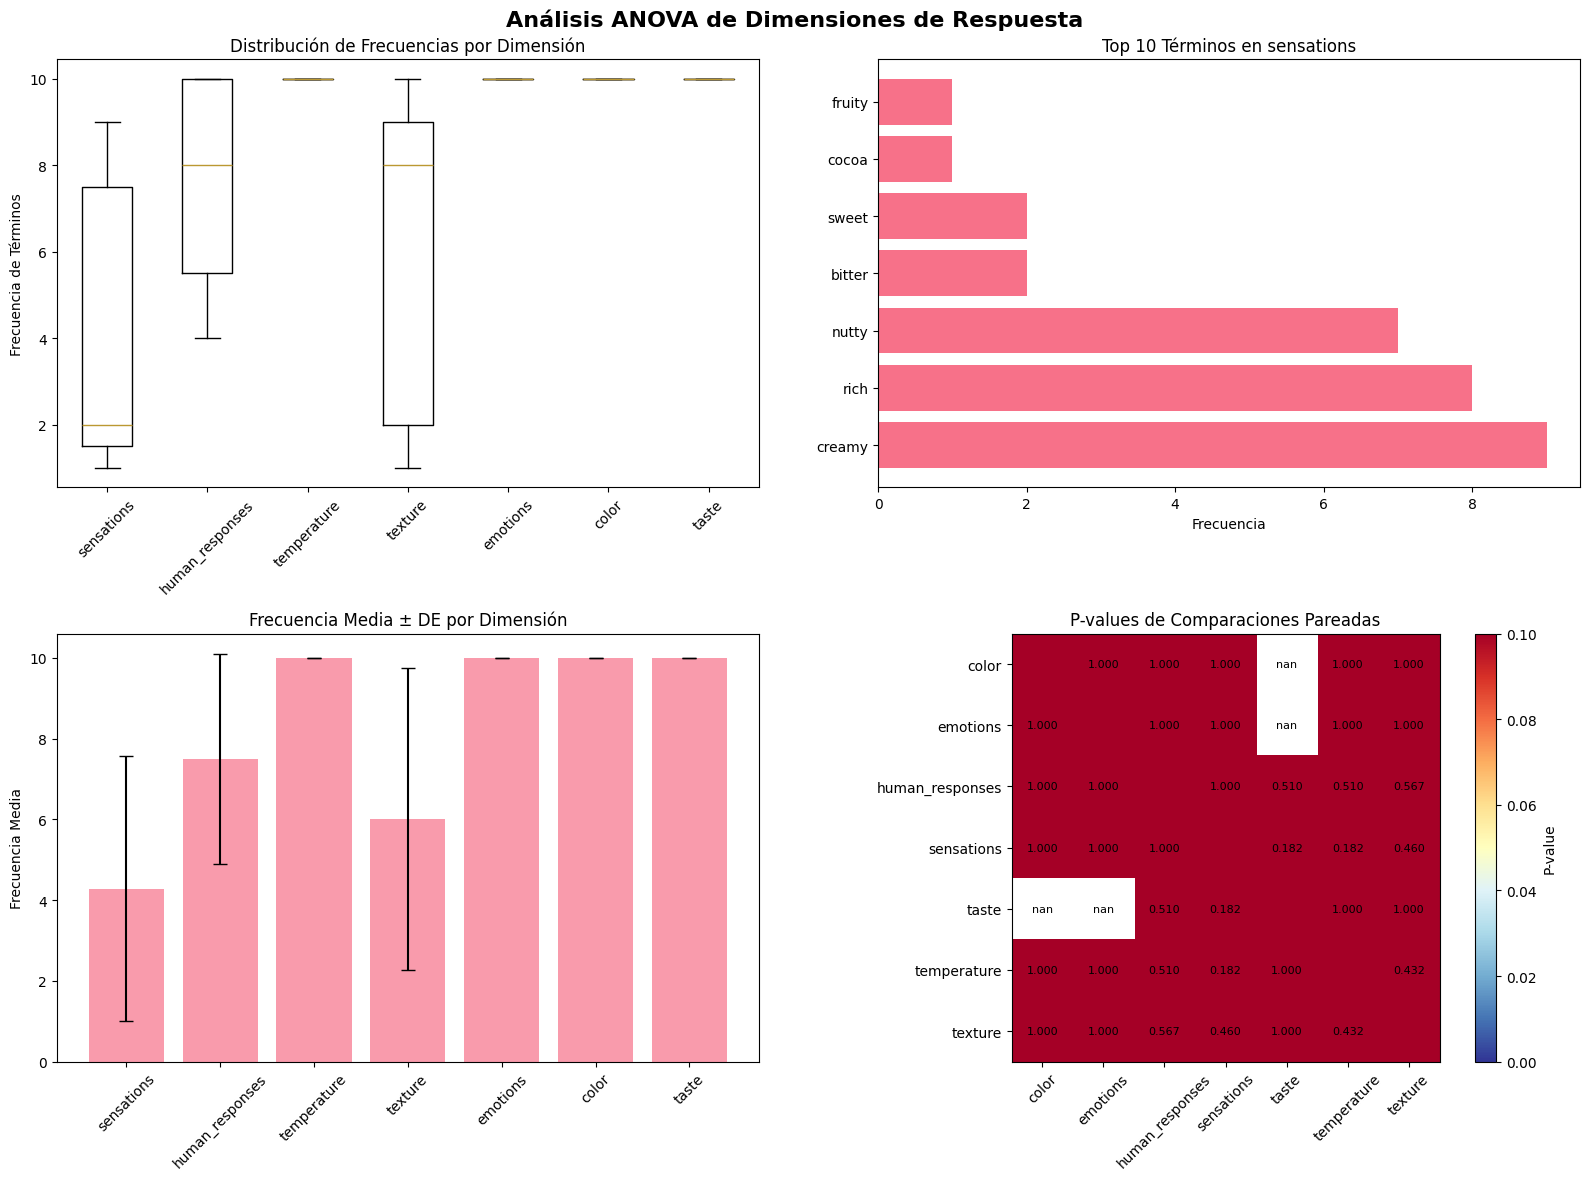


📋 RESUMEN DEL ANÁLISIS ANOVA
🔬 ANOVA General:
   F-statistic: 1.1130
   P-value: 0.4063
   Significancia: No significativo
   Dimensiones comparadas: 7

📊 Estadísticas Descriptivas:
   sensations:
     - Media frecuencia: 4.29
     - Desviación estándar: 3.28
     - Términos únicos: 7
     - Total ocurrencias: 30
   human_responses:
     - Media frecuencia: 7.50
     - Desviación estándar: 2.60
     - Términos únicos: 4
     - Total ocurrencias: 30
   temperature:
     - Media frecuencia: 10.00
     - Desviación estándar: 0.00
     - Términos únicos: 1
     - Total ocurrencias: 10
   texture:
     - Media frecuencia: 6.00
     - Desviación estándar: 3.74
     - Términos únicos: 5
     - Total ocurrencias: 30
   emotions:
     - Media frecuencia: 10.00
     - Desviación estándar: 0.00
     - Términos únicos: 1
     - Total ocurrencias: 10
   color:
     - Media frecuencia: 10.00
     - Desviación estándar: 0.00
     - Términos únicos: 1
     - Total ocurrencias: 10
   taste:
     - Med

In [9]:
def create_anova_visualizations(frequency_analysis: Dict[str, Counter], 
                               anova_results: Dict[str, Any]) -> None:
    """
    Crea visualizaciones para los resultados del análisis ANOVA
    
    Args:
        frequency_analysis: Contadores de frecuencia por dimensión
        anova_results: Resultados del análisis ANOVA
    """
    if not frequency_analysis:
        print("⚠️  No hay datos para visualizar")
        return
    
    # Configurar el estilo
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Crear figura con subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Análisis ANOVA de Dimensiones de Respuesta', fontsize=16, fontweight='bold')
    
    # 1. Distribución de frecuencias por dimensión (Box Plot)
    dimension_data = []
    dimension_labels = []
    
    for dimension, counter in frequency_analysis.items():
        if len(counter) > 0:
            frequencies = list(counter.values())
            dimension_data.append(frequencies)
            dimension_labels.append(dimension)
    
    if dimension_data:
        axes[0, 0].boxplot(dimension_data, labels=dimension_labels)
        axes[0, 0].set_title('Distribución de Frecuencias por Dimensión')
        axes[0, 0].set_ylabel('Frecuencia de Términos')
        axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Términos más frecuentes por dimensión
    if len(frequency_analysis) > 0:
        # Seleccionar una dimensión representativa para mostrar
        sample_dimension = list(frequency_analysis.keys())[0]
        sample_counter = frequency_analysis[sample_dimension]
        
        if len(sample_counter) > 0:
            top_terms = sample_counter.most_common(10)
            terms, freqs = zip(*top_terms) if top_terms else ([], [])
            
            axes[0, 1].barh(range(len(terms)), freqs)
            axes[0, 1].set_yticks(range(len(terms)))
            axes[0, 1].set_yticklabels(terms)
            axes[0, 1].set_title(f'Top 10 Términos en {sample_dimension}')
            axes[0, 1].set_xlabel('Frecuencia')
    
    # 3. Estadísticas descriptivas por dimensión
    if 'descriptive_stats' in anova_results:
        dims = list(anova_results['descriptive_stats'].keys())
        means = [anova_results['descriptive_stats'][dim]['mean_frequency'] for dim in dims]
        stds = [anova_results['descriptive_stats'][dim]['std_frequency'] for dim in dims]
        
        x_pos = range(len(dims))
        axes[1, 0].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
        axes[1, 0].set_xticks(x_pos)
        axes[1, 0].set_xticklabels(dims, rotation=45)
        axes[1, 0].set_title('Frecuencia Media ± DE por Dimensión')
        axes[1, 0].set_ylabel('Frecuencia Media')
    
    # 4. Mapa de calor de comparaciones significativas
    if 'dimension_comparison' in anova_results and anova_results['dimension_comparison']:
        # Crear matriz de p-values
        unique_dims = set()
        for comparison in anova_results['dimension_comparison'].keys():
            dims = comparison.split('_vs_')
            unique_dims.update(dims)
        
        unique_dims = sorted(list(unique_dims))
        n_dims = len(unique_dims)
        
        if n_dims > 1:
            p_matrix = np.ones((n_dims, n_dims))
            
            for i, dim1 in enumerate(unique_dims):
                for j, dim2 in enumerate(unique_dims):
                    if i != j:
                        comparison_key = f"{min(dim1, dim2)}_vs_{max(dim1, dim2)}"
                        if comparison_key in anova_results['dimension_comparison']:
                            p_val = anova_results['dimension_comparison'][comparison_key]['p_value']
                            p_matrix[i, j] = p_val
                            p_matrix[j, i] = p_val
            
            # Crear mapa de calor
            im = axes[1, 1].imshow(p_matrix, cmap='RdYlBu_r', vmin=0, vmax=0.1)
            axes[1, 1].set_xticks(range(n_dims))
            axes[1, 1].set_yticks(range(n_dims))
            axes[1, 1].set_xticklabels(unique_dims, rotation=45)
            axes[1, 1].set_yticklabels(unique_dims)
            axes[1, 1].set_title('P-values de Comparaciones Pareadas')
            
            # Añadir colorbar
            cbar = plt.colorbar(im, ax=axes[1, 1])
            cbar.set_label('P-value')
            
            # Añadir texto con p-values
            for i in range(n_dims):
                for j in range(n_dims):
                    if i != j:
                        text_color = 'white' if p_matrix[i, j] < 0.05 else 'black'
                        axes[1, 1].text(j, i, f'{p_matrix[i, j]:.3f}', 
                                       ha='center', va='center', color=text_color, fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Resumen textual de resultados
    print("\n" + "="*60)
    print("📋 RESUMEN DEL ANÁLISIS ANOVA")
    print("="*60)
    
    if 'anova_results' in anova_results and 'f_statistic' in anova_results['anova_results']:
        results = anova_results['anova_results']
        print(f"🔬 ANOVA General:")
        print(f"   F-statistic: {results['f_statistic']:.4f}")
        print(f"   P-value: {results['p_value']:.4f}")
        print(f"   Significancia: {results['interpretation']}")
        print(f"   Dimensiones comparadas: {len(results['dimensions_compared'])}")
    
    if 'descriptive_stats' in anova_results:
        print(f"\n📊 Estadísticas Descriptivas:")
        for dim, stats in anova_results['descriptive_stats'].items():
            print(f"   {dim}:")
            print(f"     - Media frecuencia: {stats['mean_frequency']:.2f}")
            print(f"     - Desviación estándar: {stats['std_frequency']:.2f}")
            print(f"     - Términos únicos: {stats['total_terms']}")
            print(f"     - Total ocurrencias: {stats['total_occurrences']}")
    
    if 'dimension_comparison' in anova_results:
        print(f"\n🔍 Comparaciones Significativas (p < 0.05):")
        significant_comparisons = [
            comp for comp, data in anova_results['dimension_comparison'].items()
            if data['significant']
        ]
        
        if significant_comparisons:
            for comp in significant_comparisons:
                p_val = anova_results['dimension_comparison'][comp]['p_value']
                print(f"   {comp.replace('_vs_', ' vs ')}: p = {p_val:.4f}")
        else:
            print("   No se encontraron diferencias significativas entre dimensiones")

# Crear visualizaciones
if 'anova_results' in locals() and anova_results and 'frequency_analysis' in locals():
    create_anova_visualizations(frequency_analysis, anova_results)
else:
    print("⚠️  No hay datos suficientes para crear visualizaciones")

## 6.1 Word Cloud Visualizations

Creamos nubes de palabras para visualizar la frecuencia de términos en cada dimensión de manera intuitiva.

☁️  Generando nubes de palabras...
✅ WordCloud creado para: sensations
✅ WordCloud creado para: human_responses
✅ WordCloud creado para: temperature
✅ WordCloud creado para: texture
✅ WordCloud creado para: emotions
✅ WordCloud creado para: color
✅ WordCloud creado para: taste


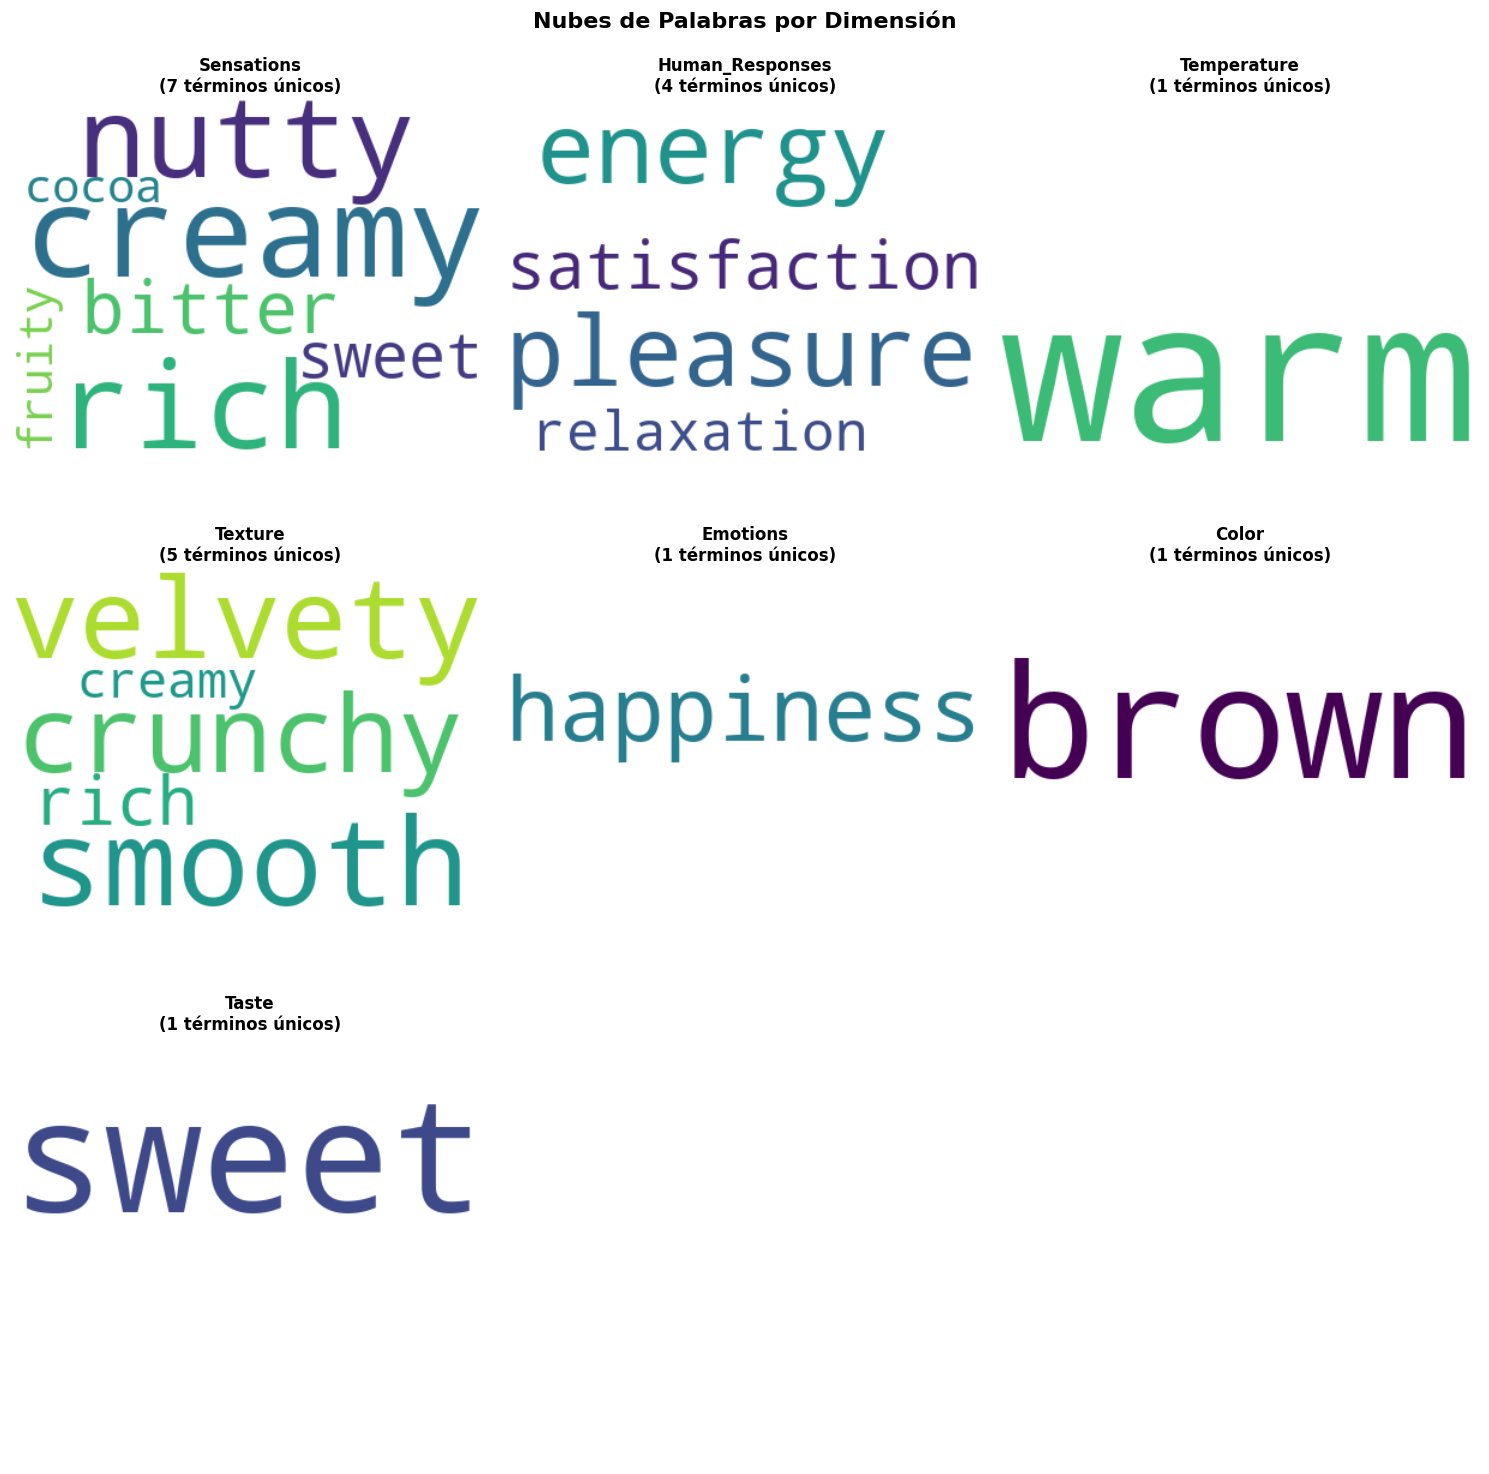


📊 Estadísticas de Nubes de Palabras:
   - Dimensiones procesadas: 7
   - Total términos únicos: 20
   - Dimensión más diversa: sensations (7 términos)
   - Top 5 términos globales: [('sweet', 12), ('rich', 10), ('creamy', 10), ('pleasure', 10), ('energy', 10)]


In [10]:
def create_word_clouds(frequency_analysis: Dict[str, Counter]) -> None:
    """
    Crea nubes de palabras para cada dimensión mostrando la frecuencia de términos
    
    Args:
        frequency_analysis: Diccionario con contadores de frecuencia por dimensión
    """
    if not wordcloud_available:
        print("⚠️  WordCloud no está disponible. Instalar con: pip install wordcloud")
        return
    
    if not frequency_analysis:
        print("⚠️  No hay datos de frecuencia para crear nubes de palabras")
        return
    
    # Configurar parámetros de WordCloud
    wordcloud_params = {
        'width': 400,
        'height': 300,
        'background_color': 'white',
        'max_words': 50,
        'colormap': 'viridis',
        'relative_scaling': 0.5,
        'min_font_size': 10
    }
    
    # Calcular número de dimensiones y organizar subplots
    dimensions = list(frequency_analysis.keys())
    n_dims = len(dimensions)
    
    if n_dims == 0:
        print("⚠️  No hay dimensiones para visualizar")
        return
    
    # Calcular filas y columnas para subplots
    cols = 3  # Máximo 3 columnas
    rows = (n_dims + cols - 1) // cols  # Redondear hacia arriba
    
    # Crear figura
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    fig.suptitle('Nubes de Palabras por Dimensión', fontsize=16, fontweight='bold')
    
    # Si solo hay una fila, asegurar que axes sea una lista
    if rows == 1:
        axes = [axes] if n_dims == 1 else axes
    elif n_dims == 1:
        axes = [axes[0, 0]]
    else:
        axes = axes.flatten()
    
    # Crear wordcloud para cada dimensión
    for i, (dimension, counter) in enumerate(frequency_analysis.items()):
        if i >= len(axes):
            break
            
        # Preparar datos para WordCloud
        if len(counter) > 0:
            # WordCloud espera un diccionario con términos y frecuencias
            word_freq = dict(counter)
            
            # Crear WordCloud
            try:
                wordcloud = WordCloud(**wordcloud_params).generate_from_frequencies(word_freq)
                
                # Mostrar en subplot
                axes[i].imshow(wordcloud, interpolation='bilinear')
                axes[i].set_title(f'{dimension.title()}\n({len(word_freq)} términos únicos)', 
                                fontsize=12, fontweight='bold')
                axes[i].axis('off')
                
                print(f"✅ WordCloud creado para: {dimension}")
                
            except Exception as e:
                print(f"❌ Error creando WordCloud para {dimension}: {e}")
                axes[i].text(0.5, 0.5, f'Error en\n{dimension}', 
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(dimension.title(), fontsize=12)
                axes[i].axis('off')
        else:
            # Si no hay datos para esta dimensión
            axes[i].text(0.5, 0.5, f'Sin datos\npara\n{dimension}', 
                       ha='center', va='center', transform=axes[i].transAxes,
                       fontsize=12)
            axes[i].set_title(dimension.title(), fontsize=12)
            axes[i].axis('off')
    
    # Ocultar subplots vacíos
    for i in range(n_dims, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de las nubes de palabras
    print(f"\n📊 Estadísticas de Nubes de Palabras:")
    print(f"   - Dimensiones procesadas: {n_dims}")
    print(f"   - Total términos únicos: {sum(len(counter) for counter in frequency_analysis.values())}")
    
    # Mostrar dimensión más diversa
    most_diverse = max(frequency_analysis.items(), key=lambda x: len(x[1]))
    print(f"   - Dimensión más diversa: {most_diverse[0]} ({len(most_diverse[1])} términos)")
    
    # Mostrar términos más frecuentes globalmente
    all_terms = Counter()
    for counter in frequency_analysis.values():
        all_terms.update(counter)
    
    if len(all_terms) > 0:
        top_global = all_terms.most_common(5)
        print(f"   - Top 5 términos globales: {top_global}")

# Crear nubes de palabras
if 'frequency_analysis' in locals() and frequency_analysis:
    print("☁️  Generando nubes de palabras...")
    create_word_clouds(frequency_analysis)
else:
    print("⚠️  No hay análisis de frecuencias disponible para las nubes de palabras")

### 6.2 Comparative Word Cloud Analysis

Análisis comparativo de nubes de palabras con métricas adicionales por dimensión.

🔍 Iniciando análisis comparativo de nubes de palabras...


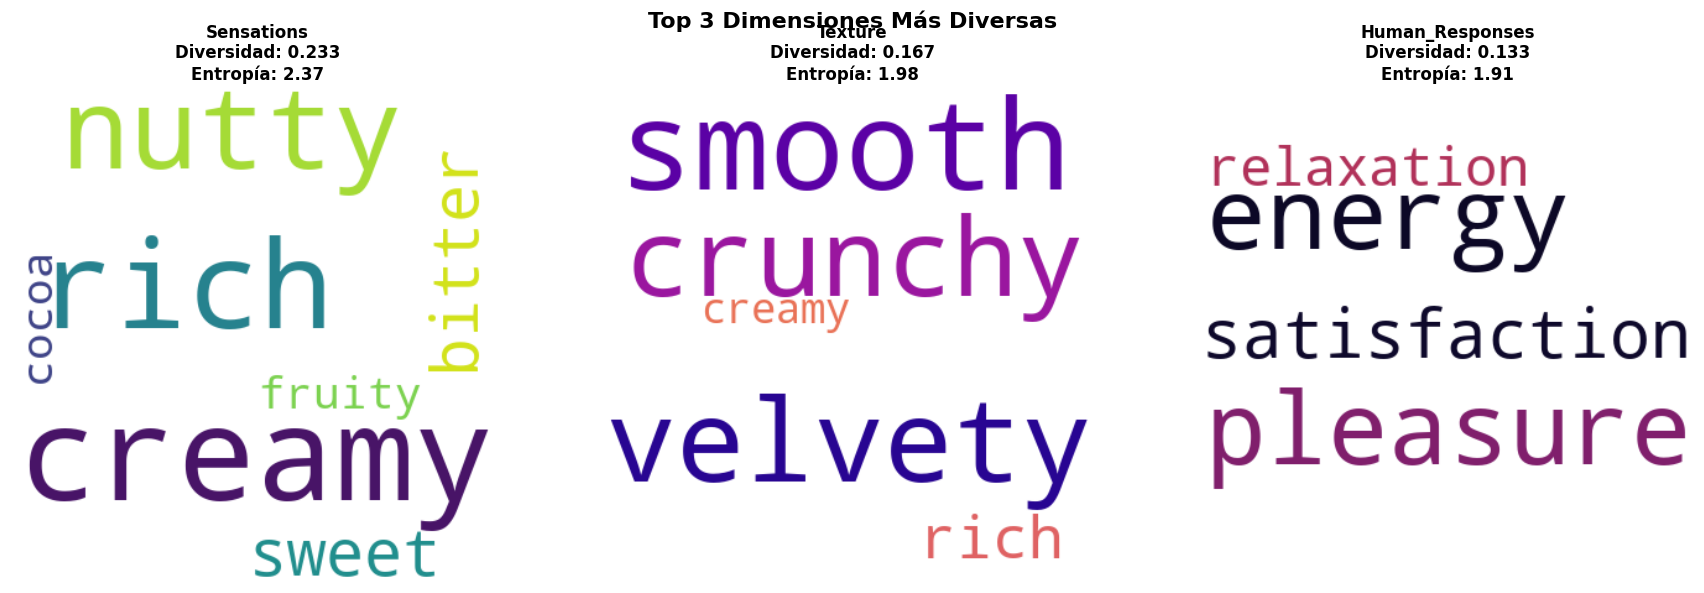


🔍 ANÁLISIS DE TÉRMINOS ÚNICOS:
   - Términos exclusivos: 14
   - Términos compartidos: 3
   - Término más compartido: 'sweet' (2 dimensiones)


In [12]:
def create_comparative_word_clouds(frequency_analysis: Dict[str, Counter], 
                                  top_n: int = 3) -> None:
    """
    Crea análisis comparativo de nubes de palabras mostrando las dimensiones 
    con mayor diversidad léxica
    
    Args:
        frequency_analysis: Diccionario con contadores de frecuencia por dimensión
        top_n: Número de dimensiones top a mostrar en detalle
    """
    if not wordcloud_available:
        print("⚠️  WordCloud no está disponible para análisis comparativo")
        return
        
    if not frequency_analysis:
        print("⚠️  No hay datos para análisis comparativo")
        return
    
    # Calcular métricas de diversidad por dimensión
    diversity_metrics = {}
    for dimension, counter in frequency_analysis.items():
        total_terms = sum(counter.values())
        unique_terms = len(counter)
        
        # Métricas de diversidad
        diversity_metrics[dimension] = {
            'total_terms': total_terms,
            'unique_terms': unique_terms,
            'diversity_ratio': unique_terms / total_terms if total_terms > 0 else 0,
            'entropy': -sum((freq/total_terms) * np.log2(freq/total_terms) 
                           for freq in counter.values()) if total_terms > 0 else 0,
            'max_frequency': max(counter.values()) if counter else 0,
            'counter': counter
        }
    
    # Ordenar por diversidad (ratio de términos únicos)
    sorted_dimensions = sorted(diversity_metrics.items(), 
                             key=lambda x: x[1]['diversity_ratio'], reverse=True)
    """
    print(f"📊 ANÁLISIS DE DIVERSIDAD LÉXICA")
    print("="*50)
    
    for i, (dimension, metrics) in enumerate(sorted_dimensions, 1):
        print(f"{i}. {dimension.upper()}:")
        print(f"   - Términos únicos: {metrics['unique_terms']}")
        print(f"   - Total términos: {metrics['total_terms']}")
        print(f"   - Ratio diversidad: {metrics['diversity_ratio']:.3f}")
        print(f"   - Entropía: {metrics['entropy']:.3f}")
        print()
    """
    # Mostrar nubes de palabras para las top N dimensiones más diversas
    if len(sorted_dimensions) > 0:
        top_dimensions = sorted_dimensions[:min(top_n, len(sorted_dimensions))]
        
        fig, axes = plt.subplots(1, len(top_dimensions), 
                                figsize=(6 * len(top_dimensions), 6))
        
        if len(top_dimensions) == 1:
            axes = [axes]
        
        fig.suptitle(f'Top {len(top_dimensions)} Dimensiones Más Diversas', 
                    fontsize=16, fontweight='bold')
        
        # Definir colores diferentes para cada dimensión
        color_schemes = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
        
        for i, (dimension, metrics) in enumerate(top_dimensions):
            counter = metrics['counter']
            
            if len(counter) > 0:
                # Configurar WordCloud con esquema de color único
                wordcloud_params = {
                    'width': 400,
                    'height': 400,
                    'background_color': 'white',
                    'max_words': 30,
                    'colormap': color_schemes[i % len(color_schemes)],
                    'relative_scaling': 0.6,
                    'min_font_size': 8,
                    'prefer_horizontal': 0.7
                }
                
                try:
                    wordcloud = WordCloud(**wordcloud_params).generate_from_frequencies(
                        dict(counter))
                    
                    axes[i].imshow(wordcloud, interpolation='bilinear')
                    axes[i].set_title(
                        f'{dimension.title()}\nDiversidad: {metrics["diversity_ratio"]:.3f}\n'
                        f'Entropía: {metrics["entropy"]:.2f}',
                        fontsize=12, fontweight='bold'
                    )
                    axes[i].axis('off')
                    
                except Exception as e:
                    axes[i].text(0.5, 0.5, f'Error\n{dimension}', 
                               ha='center', va='center', transform=axes[i].transAxes)
                    axes[i].set_title(dimension.title())
                    axes[i].axis('off')
            else:
                axes[i].text(0.5, 0.5, 'Sin datos', ha='center', va='center',
                           transform=axes[i].transAxes)
                axes[i].set_title(dimension.title())
                axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Análisis de términos únicos vs comunes
        print(f"\n🔍 ANÁLISIS DE TÉRMINOS ÚNICOS:")
        
        # Encontrar términos que aparecen en múltiples dimensiones
        all_terms = set()
        for counter in frequency_analysis.values():
            all_terms.update(counter.keys())
        
        # Contar en cuántas dimensiones aparece cada término
        term_dimension_count = Counter()
        for term in all_terms:
            count = sum(1 for counter in frequency_analysis.values() if term in counter)
            term_dimension_count[term] = count
        
        # Términos exclusivos (solo en una dimensión)
        exclusive_terms = [term for term, count in term_dimension_count.items() if count == 1]
        shared_terms = [term for term, count in term_dimension_count.items() if count > 1]
        
        print(f"   - Términos exclusivos: {len(exclusive_terms)}")
        print(f"   - Términos compartidos: {len(shared_terms)}")
        
        if shared_terms:
            most_shared = max(term_dimension_count.items(), key=lambda x: x[1])
            print(f"   - Término más compartido: '{most_shared[0]}' ({most_shared[1]} dimensiones)")

# Ejecutar análisis comparativo
if 'frequency_analysis' in locals() and frequency_analysis:
    print("🔍 Iniciando análisis comparativo de nubes de palabras...")
    create_comparative_word_clouds(frequency_analysis, top_n=3)
else:
    print("⚠️  No hay análisis de frecuencias para comparación")

### 6.3 Alternative Text-Based Word Frequency Visualizations

Visualizaciones alternativas cuando WordCloud no está disponible, usando barras horizontales para mostrar frecuencias de términos.

📊 Creando visualizaciones de frecuencia de términos...


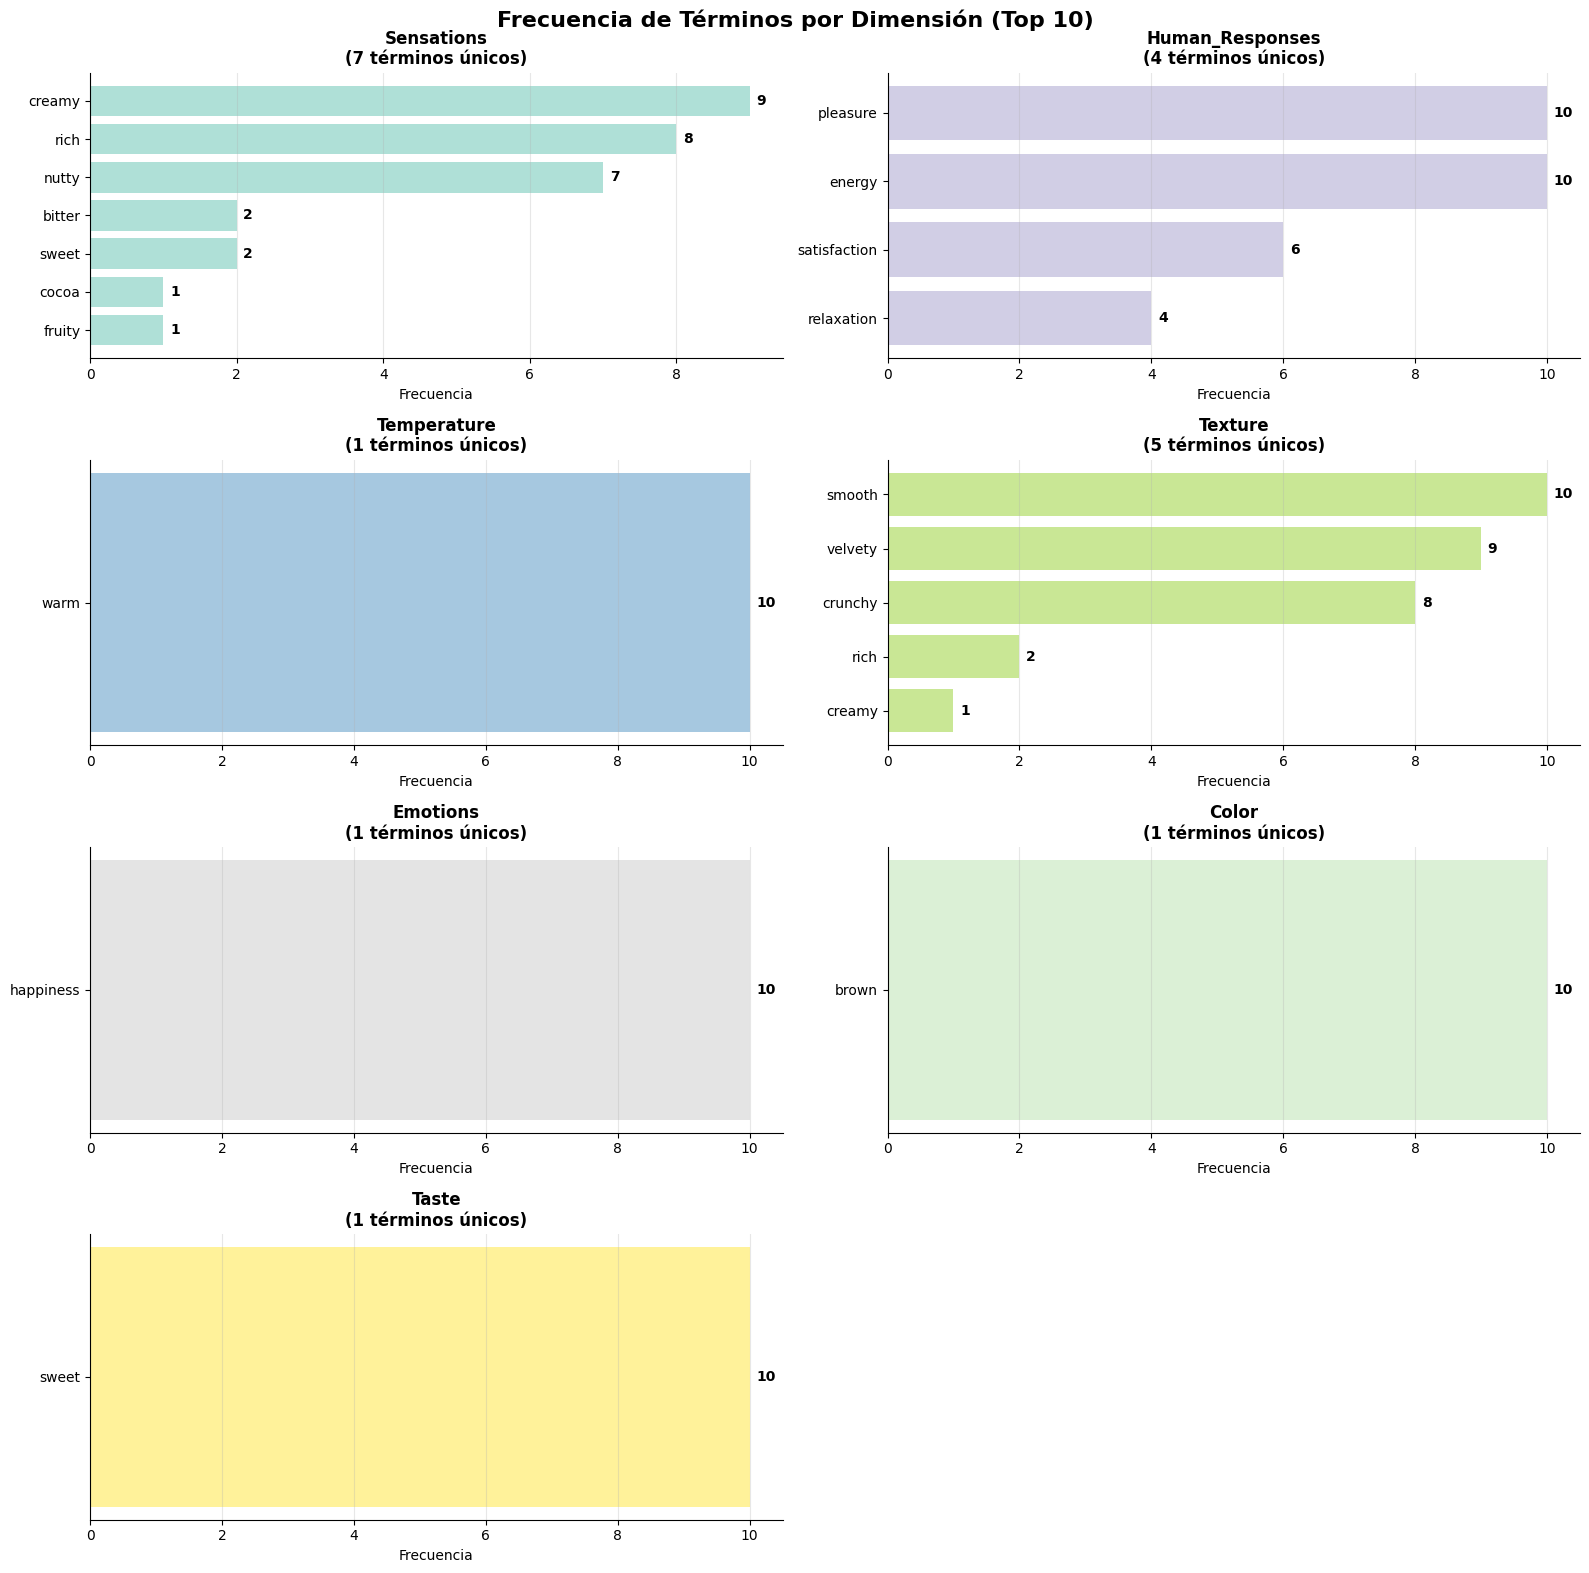


📊 Creando gráfico de diversidad léxica...


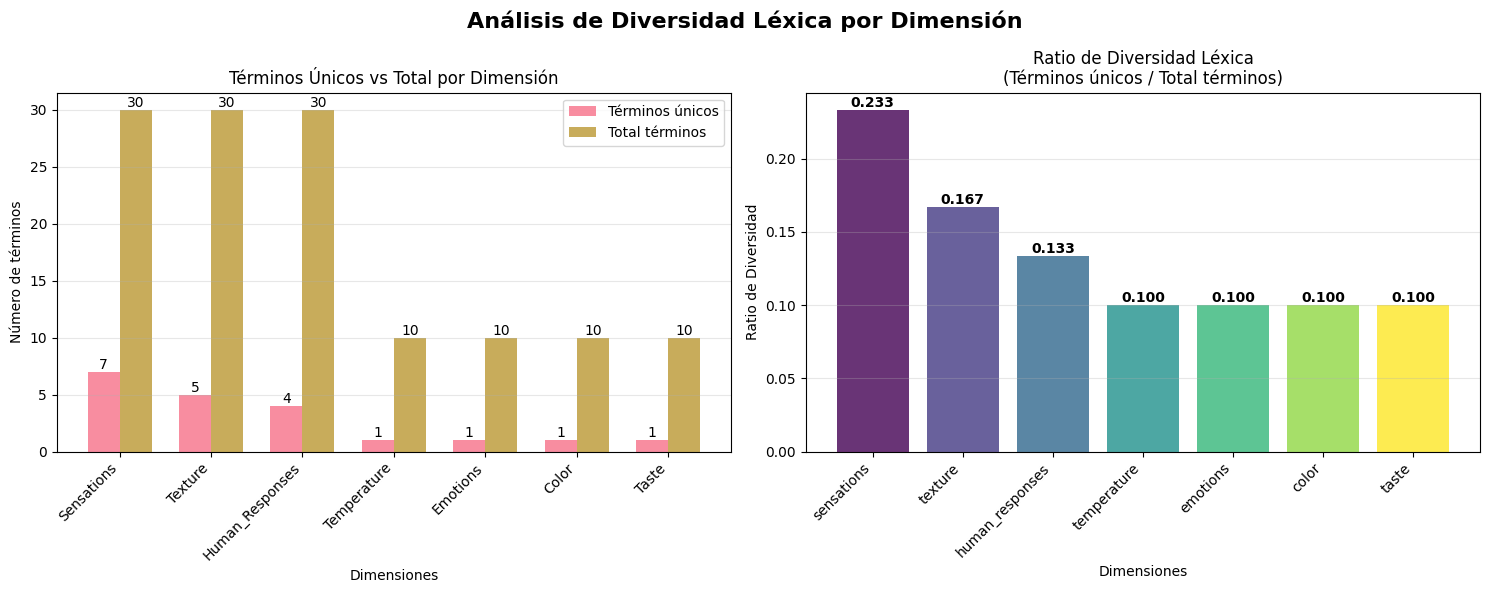


📈 RESUMEN DE VISUALIZACIONES:
   - Dimensiones analizadas: 7
   - Terms por dimensión (top 10 mostrados)
   - Más diversa: sensations (0.233)
   - Menos diversa: temperature (0.100)


In [13]:
def create_text_frequency_visualizations(frequency_analysis: Dict[str, Counter], 
                                        top_terms: int = 10) -> None:
    """
    Crea visualizaciones alternativas de frecuencia de términos usando barras horizontales
    cuando WordCloud no está disponible
    
    Args:
        frequency_analysis: Diccionario con contadores de frecuencia por dimensión
        top_terms: Número de términos top a mostrar por dimensión
    """
    if not frequency_analysis:
        print("⚠️  No hay datos de frecuencia para visualizar")
        return
    
    dimensions = list(frequency_analysis.keys())
    n_dims = len(dimensions)
    
    if n_dims == 0:
        print("⚠️  No hay dimensiones para visualizar")
        return
    
    # Configurar subplots
    cols = 2
    rows = (n_dims + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    fig.suptitle('Frecuencia de Términos por Dimensión (Top 10)', 
                fontsize=16, fontweight='bold')
    
    # Manejar el caso de un solo subplot
    if n_dims == 1:
        axes = [axes] if rows * cols == 1 else [axes[0]]
    elif rows == 1:
        axes = [axes] if n_dims == 1 else axes
    else:
        axes = axes.flatten()
    
    # Paleta de colores
    colors = plt.cm.Set3(np.linspace(0, 1, n_dims))
    
    for i, (dimension, counter) in enumerate(frequency_analysis.items()):
        if i >= len(axes):
            break
            
        ax = axes[i]
        
        if len(counter) > 0:
            # Obtener top términos
            top_items = counter.most_common(top_terms)
            terms, frequencies = zip(*top_items) if top_items else ([], [])
            
            # Crear barras horizontales
            y_pos = np.arange(len(terms))
            bars = ax.barh(y_pos, frequencies, color=colors[i], alpha=0.7)
            
            # Configurar ejes
            ax.set_yticks(y_pos)
            ax.set_yticklabels(terms)
            ax.invert_yaxis()  # Términos con mayor frecuencia arriba
            ax.set_xlabel('Frecuencia')
            ax.set_title(f'{dimension.title()}\n({len(counter)} términos únicos)', 
                        fontsize=12, fontweight='bold')
            
            # Añadir valores en las barras
            for j, (bar, freq) in enumerate(zip(bars, frequencies)):
                width = bar.get_width()
                ax.text(width + max(frequencies) * 0.01, bar.get_y() + bar.get_height()/2,
                       f'{freq}', ha='left', va='center', fontweight='bold')
            
            # Grid para facilitar lectura
            ax.grid(axis='x', alpha=0.3)
            
        else:
            ax.text(0.5, 0.5, f'Sin datos para\n{dimension}', 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=14)
            ax.set_title(dimension.title(), fontsize=12)
        
        # Remover spines innecesarios
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Ocultar subplots vacíos
    for i in range(n_dims, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Crear gráfico de barras comparativo por diversidad
    print("\n📊 Creando gráfico de diversidad léxica...")
    
    # Calcular métricas de diversidad
    diversity_data = []
    for dimension, counter in frequency_analysis.items():
        total_terms = sum(counter.values())
        unique_terms = len(counter)
        diversity_ratio = unique_terms / total_terms if total_terms > 0 else 0
        
        diversity_data.append({
            'dimension': dimension,
            'unique_terms': unique_terms,
            'total_terms': total_terms,
            'diversity_ratio': diversity_ratio
        })
    
    # Ordenar por ratio de diversidad
    diversity_data.sort(key=lambda x: x['diversity_ratio'], reverse=True)
    
    # Crear gráfico de diversidad
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Análisis de Diversidad Léxica por Dimensión', fontsize=16, fontweight='bold')
    
    # Gráfico 1: Términos únicos vs totales
    dimensions_names = [d['dimension'] for d in diversity_data]
    unique_counts = [d['unique_terms'] for d in diversity_data]
    total_counts = [d['total_terms'] for d in diversity_data]
    
    x = np.arange(len(dimensions_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, unique_counts, width, label='Términos únicos', alpha=0.8)
    bars2 = ax1.bar(x + width/2, total_counts, width, label='Total términos', alpha=0.8)
    
    ax1.set_xlabel('Dimensiones')
    ax1.set_ylabel('Número de términos')
    ax1.set_title('Términos Únicos vs Total por Dimensión')
    ax1.set_xticks(x)
    ax1.set_xticklabels([d.title() for d in dimensions_names], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Añadir valores en las barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
    
    # Gráfico 2: Ratio de diversidad
    diversity_ratios = [d['diversity_ratio'] for d in diversity_data]
    bars3 = ax2.bar(dimensions_names, diversity_ratios, 
                    color=plt.cm.viridis(np.linspace(0, 1, len(dimensions_names))), 
                    alpha=0.8)
    
    ax2.set_xlabel('Dimensiones')
    ax2.set_ylabel('Ratio de Diversidad')
    ax2.set_title('Ratio de Diversidad Léxica\n(Términos únicos / Total términos)')
    ax2.set_xticklabels(dimensions_names, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    
    # Añadir valores en las barras
    for bar, ratio in zip(bars3, diversity_ratios):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{ratio:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Resumen textual
    print(f"\n📈 RESUMEN DE VISUALIZACIONES:")
    print(f"   - Dimensiones analizadas: {n_dims}")
    print(f"   - Terms por dimensión (top {top_terms} mostrados)")
    
    most_diverse = max(diversity_data, key=lambda x: x['diversity_ratio'])
    least_diverse = min(diversity_data, key=lambda x: x['diversity_ratio'])
    
    print(f"   - Más diversa: {most_diverse['dimension']} ({most_diverse['diversity_ratio']:.3f})")
    print(f"   - Menos diversa: {least_diverse['dimension']} ({least_diverse['diversity_ratio']:.3f})")

# Ejecutar visualizaciones alternativas (siempre disponibles)
if 'frequency_analysis' in locals() and frequency_analysis:
    print("📊 Creando visualizaciones de frecuencia de términos...")
    create_text_frequency_visualizations(frequency_analysis, top_terms=10)
else:
    print("⚠️  No hay análisis de frecuencias para las visualizaciones")